In [1]:
# Libraries

In [2]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.losses import Loss
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, BatchNormalization, 
                                     ReLU, Add, Dropout, LSTM, MultiHeadAttention, Reshape,Flatten)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve, precision_recall_curve, classification_report
)
import tensorflow as tf
import shap
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tf_explain.core.grad_cam import GradCAM
import json

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
# Data Loading and Preprocessing

In [4]:
root_dir = r'D:\Multi-Class Diabetic Retinopathy Classification\data\aptos2019-blindness-detection'
train_dir = os.path.join(root_dir, "train")
test_dir = os.path.join(root_dir, "test")

In [5]:
# Image preprocessing and augmentation
def preprocess_image(image):

    h, w, _ = image.shape
    center_x, center_y = w // 2, h // 2
    crop_size = min(center_x, center_y)  
    cropped_image = image[
        center_y - crop_size:center_y + crop_size,
        center_x - crop_size:center_x + crop_size
    ]

    resized_image = cv2.resize(cropped_image, (224, 224))

    normalized_image = resized_image / 255.0  
    return normalized_image

train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=120,         
    preprocessing_function=preprocess_image, 
    validation_split=0.2
)
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [6]:
# Load and preprocess the training and testing images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training', 
    shuffle=True  
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
print("Class indices mapping:", train_generator.class_indices)

Found 2345 images belonging to 5 classes.
Found 584 images belonging to 5 classes.
Found 733 images belonging to 5 classes.
Class indices mapping: {'0 - No DR': 0, '1 - Mild': 1, '2 - Moderate': 2, '3 - Severe': 3, '4 - Proliferative DR': 4}


In [7]:
# Model Definition

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation, Add, 
                                     MaxPooling2D, Dense, LSTM, GRU, MultiHeadAttention, 
                                     Reshape, LayerNormalization)
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import he_normal

def identity_block(X, kernel_size, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base   = 'bn'  + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters
    X_shortcut = X

    # 1x1
    X = Conv2D(F1, (1,1), strides=(1,1), padding='valid',
               name=conv_name_base + '2a', kernel_initializer=he_normal(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # 3x3
    X = Conv2D(F2, kernel_size, strides=(1,1), padding='same',
               name=conv_name_base + '2b', kernel_initializer=he_normal(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    
    # 1x1
    X = Conv2D(F3, (1,1), strides=(1,1), padding='valid',
               name=conv_name_base + '2c', kernel_initializer=he_normal(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)
    
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

def convolutional_block(X, kernel_size, filters, stage, block, strides=(2,2)):
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base   = 'bn'  + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters
    X_shortcut = X

    # 1x1
    X = Conv2D(F1, (1,1), strides=strides, padding='valid',
               name=conv_name_base + '2a', kernel_initializer=he_normal(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # 3x3
    X = Conv2D(F2, kernel_size, strides=(1,1), padding='same',
               name=conv_name_base + '2b', kernel_initializer=he_normal(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    
    # 1x1
    X = Conv2D(F3, (1,1), strides=(1,1), padding='valid',
               name=conv_name_base + '2c', kernel_initializer=he_normal(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)
    
    # shortcut
    X_shortcut = Conv2D(F3, (1,1), strides=strides, padding='valid',
                        name=conv_name_base + '1', kernel_initializer=he_normal(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)
    
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

def ResNet50_Light_MHA_GRU(input_shape=(224,224,3), classes=5, alpha=0.5):
    
    X_input = Input(input_shape)
    
    # Stage 1
    X = Conv2D(64, (7,7), strides=(2,2), padding='same', name='conv1',
               kernel_initializer=he_normal(seed=0))(X_input)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3,3), strides=(2,2), padding='same')(X)
    
    # Stage 2
    filters2 = [int(64*alpha), int(64*alpha), int(256*alpha)]
    X = convolutional_block(X, (3,3), filters2, stage=2, block='a', strides=(1,1))
    X = identity_block(X, (3,3), filters2, stage=2, block='b')
    X = identity_block(X, (3,3), filters2, stage=2, block='c')
    
    # Stage 3
    filters3 = [int(128*alpha), int(128*alpha), int(512*alpha)]
    X = convolutional_block(X, (3,3), filters3, stage=3, block='a', strides=(2,2))
   
    X = identity_block(X, (3,3), filters3, stage=3, block='b')
    X = identity_block(X, (3,3), filters3, stage=3, block='c')
    
    # Stage 4
    filters4 = [int(256*alpha), int(256*alpha), int(1024*alpha)]
    X = convolutional_block(X, (3,3), filters4, stage=4, block='a', strides=(2,2))
   
    X = identity_block(X, (3,3), filters4, stage=4, block='b')
    X = identity_block(X, (3,3), filters4, stage=4, block='c')
    
    # Stage 5
    filters5 = [int(512*alpha), int(512*alpha), int(2048*alpha)]
    X = convolutional_block(X, (3,3), filters5, stage=5, block='a', strides=(2,2))
    X = identity_block(X, (3,3), filters5, stage=5, block='b')
    X = identity_block(X, (3,3), filters5, stage=5, block='c')
    
    
    X = Conv2D(512, (1,1), strides=(1,1), padding='same',
               name='reduce_channels', kernel_initializer=he_normal(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_reduce')(X)
    X = Activation('relu')(X)
    
   
    shape = tf.keras.backend.int_shape(X)  
    seq_len = shape[1] * shape[2]
    X_seq = Reshape((seq_len, shape[3]))(X)
    
    # Multi-Head Attention
    mha = MultiHeadAttention(num_heads=2, key_dim=64)
    X_attn = mha(query=X_seq, value=X_seq, key=X_seq)
    X_attn = Add()([X_seq, X_attn])
    X_attn = LayerNormalization()(X_attn)

    lstm_out = LSTM(64)(X_attn)
    outputs = Dense(classes, activation='softmax', name='fc')(lstm_out)
    model = Model(inputs=X_input, outputs=outputs)

    return model

model= ResNet50_Light_MHA_GRU(input_shape=(224,224,3), classes=5, alpha=0.5)
model.summary()


Model: "ResNet50_Light_MHA_GRU"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           bn_conv1[0][0]                   
_____________________________________________________________________________

In [26]:


def compute_class_balanced_weights(num_samples, beta=0.99):
    effective_num = 1.0 - np.power(beta, num_samples)
    weights = (1.0 - beta) / effective_num

    weights = weights / np.mean(weights)
    return weights

class CustomLossWithSmoothing(Loss):
    def __init__(self, weights, gamma=2.0, label_smoothing=0.1, **kwargs):

        super().__init__(**kwargs)
        self.weights = tf.constant(weights, dtype=tf.float32)
        self.gamma = gamma
        self.label_smoothing = label_smoothing

    def call(self, y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        num_classes = tf.cast(tf.shape(y_true)[-1], tf.float32)
        y_true_smoothed = y_true * (1.0 - self.label_smoothing) + self.label_smoothing / num_classes
        cross_entropy = -y_true_smoothed * K.log(y_pred)
        focal_factor = K.pow(1 - y_pred, self.gamma)
        loss = K.sum(self.weights * focal_factor * cross_entropy, axis=-1)
        return loss

    def get_config(self):
        config = super().get_config()
        config.update({
            "gamma": self.gamma,
            "label_smoothing": self.label_smoothing
        })
        return config

train_labels = train_generator.classes  
num_samples_per_class = np.bincount(train_labels) 
total_samples = len(train_labels)  
num_classes = len(num_samples_per_class)  
class_weights = total_samples / (num_classes * num_samples_per_class)

custom_loss = CustomLossWithSmoothing(weights=class_weights, gamma=2.0, label_smoothing=0.1)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
              loss=custom_loss,
              metrics=['accuracy'])


In [10]:
# Model Training

In [11]:
checkpoint = ModelCheckpoint('model_best.h5',  
                             monitor='val_loss',
                             save_best_only=True, 
                             mode='min') 

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=10, 
                               mode='min',
                               restore_best_weights=True) 

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1, 
                              patience=5,  
                              min_lr=0.00002,
                              mode='min',
                              verbose=1 )


In [12]:
history = model.fit(
    train_generator, 
    validation_data=validation_generator,
    steps_per_epoch = len(train_generator),
    validation_steps = len(validation_generator),
    epochs=30,  
    callbacks=[checkpoint, early_stopping, reduce_lr],
    workers=6,  
    max_queue_size=20
)

Epoch 1/30
74/74 [==============================] - 40s 421ms/step - loss: 33.2509 - accuracy: 0.6021 - val_loss: 40.2712 - val_accuracy: 0.4024


Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.


Epoch 2/30
74/74 [==============================] - 33s 431ms/step - loss: 27.8237 - accuracy: 0.6814 - val_loss: 60.2655 - val_accuracy: 0.2945
Epoch 3/30
74/74 [==============================] - 33s 423ms/step - loss: 26.7690 - accuracy: 0.6832 - val_loss: 57.6373 - val_accuracy: 0.3305
Epoch 4/30
74/74 [==============================] - 33s 415ms/step - loss: 25.3147 - accuracy: 0.6981 - val_loss: 51.9326 - val_accuracy: 0.3664
Epoch 5/30
74/74 [==============================] - 33s 421ms/step - loss: 25.2813 - accuracy: 0.7049 - val_loss: 30.3856 - val_accuracy: 0.6455
Epoch 6/30
74/74 [==============================] - 33s 415ms/step - loss: 24.6390 - accuracy: 0.7041 - val_loss: 25.5719 - val_accuracy: 0.7038
Epoch 7/30
74/74 [==============================] - 32s 413ms/step - loss: 23.9116 - accuracy: 0.7096 - val_loss: 25.8339 - val_accuracy: 0.6935
Epoch 8/30
74/74 [==============================] - 32s 423ms/step - loss: 23.8607 - accuracy: 0.7079 - val_loss: 25.6458 - val_ac

In [13]:
# Model Evaluation

In [14]:
save_dir='plots'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

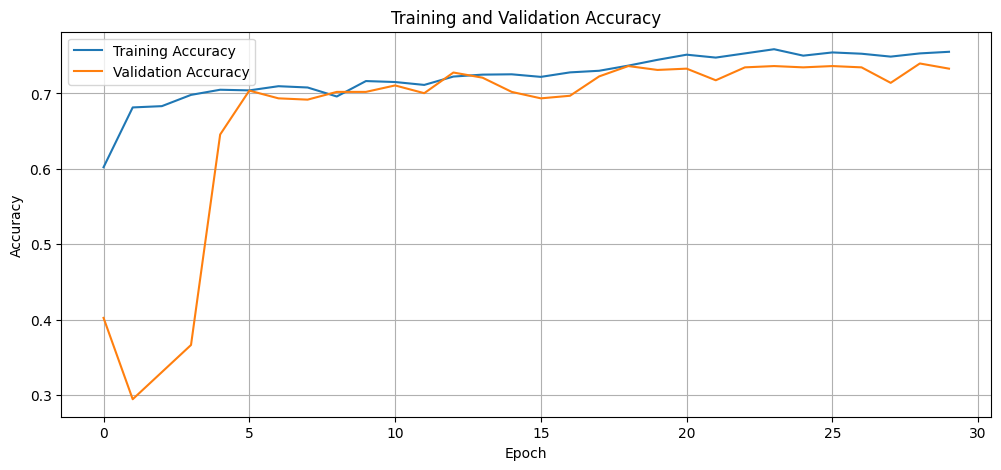

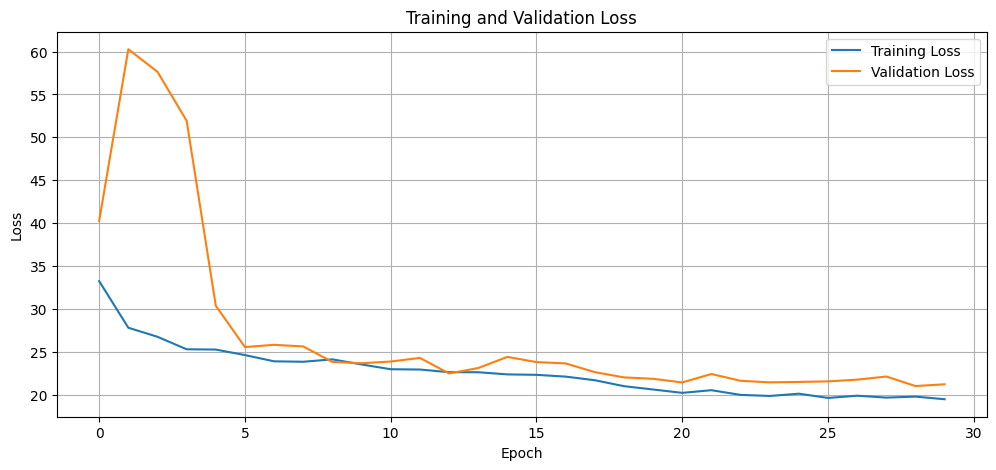

In [15]:
# Plot the training and validation loss and accuracy curves
plt.figure(figsize=(12, 5))
# Accuracy curves
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, 'accuracy_plot.png'), dpi=600, bbox_inches='tight')
plt.show()
# Plot the training and validation loss and accuracy curves
plt.figure(figsize=(12, 5))
# Loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, 'loss_plot.png'), dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
# Model Loading
model = load_model('model_best.h5', custom_objects={'CustomLossWithSmoothing': CustomLossWithSmoothing})

In [18]:
# Prediction and Inference

In [19]:
# Make predictions on the test data
predictions = model.predict(test_generator)  
true_labels = test_generator.classes  
class_labels = list(test_generator.class_indices.keys())  
predicted_classes = np.argmax(predictions, axis=1)

In [20]:
# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

def evaluate_model(true_labels, predicted_classes, class_labels, save_dir):
    # Ensure save directory exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Micro average accuracy
    micro_accuracy = accuracy_score(true_labels, predicted_classes)
    
    # Generate classification report
    classification_report_dict = classification_report(
        true_labels, predicted_classes, target_names=class_labels, output_dict=True, zero_division=0
    )

    # Calculate specificity and accuracy per class
    specificity_per_class = []
    accuracy_per_class = []
    total_tn, total_fp = 0, 0  # For micro-average specificity
    for i in range(len(class_labels)):
        true_negative = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
        false_positive = np.sum(cm[:, i]) - cm[i, i]
        specificity = true_negative / (true_negative + false_positive) if (true_negative + false_positive) > 0 else 0.0
        specificity_per_class.append(specificity)

        accuracy = cm[i, i] / np.sum(cm[i, :]) if np.sum(cm[i, :]) > 0 else 0.0
        accuracy_per_class.append(accuracy)

        total_tn += true_negative
        total_fp += false_positive

    # Calculate macro and micro average specificity
    macro_specificity = np.mean(specificity_per_class)
    micro_specificity = total_tn / (total_tn + total_fp) if (total_tn + total_fp) > 0 else 0.0

    # Save classification report as JSON
    json_save_path = os.path.join(save_dir, "classification_report.json")
    with open(json_save_path, "w") as f:
        json.dump(classification_report_dict, f, indent=4)
    print(f"Classification Report saved to {json_save_path}")

    # Print classification report
    print("Classification Report:")
    print(f"{'Class':<20} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Specificity':<12} {'Accuracy':<12} {'Support':<12}")
    for idx, cls in enumerate(class_labels):
        metrics = classification_report_dict[cls]
        print(f"{cls:<20} {metrics['precision']:<12.2f} {metrics['recall']:<12.2f} {metrics['f1-score']:<12.2f} {specificity_per_class[idx]:<12.2f} {accuracy_per_class[idx]:<12.2f} {metrics['support']:<12}")

    # Calculate macro average accuracy
    macro_accuracy = np.mean(accuracy_per_class)

    # Print micro average accuracy
    print(f"\nMicro Average Accuracy: {micro_accuracy:.2f}")
    
    # Print macro average accuracy
    print(f"Macro Average Accuracy: {macro_accuracy:.2f}")

    # Macro and Micro average metrics
    macro_precision = precision_score(true_labels, predicted_classes, average='macro', zero_division=0)
    macro_recall = recall_score(true_labels, predicted_classes, average='macro', zero_division=0)
    macro_f1 = f1_score(true_labels, predicted_classes, average='macro', zero_division=0)

    micro_precision = precision_score(true_labels, predicted_classes, average='micro', zero_division=0)
    micro_recall = recall_score(true_labels, predicted_classes, average='micro', zero_division=0)
    micro_f1 = f1_score(true_labels, predicted_classes, average='micro', zero_division=0)

    print("\nMacro Average Metrics:")
    print(f"Precision: {macro_precision:.2f}, Recall: {macro_recall:.2f}, F1-Score: {macro_f1:.2f}, Specificity: {macro_specificity:.2f}")

    print("\nMicro Average Metrics:")
    print(f"Precision: {micro_precision:.2f}, Recall: {micro_recall:.2f}, F1-Score: {micro_f1:.2f}, Specificity: {micro_specificity:.2f}")

evaluate_model(true_labels, predicted_classes, class_labels, save_dir)


Classification Report saved to plots\classification_report.json
Classification Report:
Class                Precision    Recall       F1-Score     Specificity  Accuracy     Support     
0 - No DR            0.92         0.97         0.94         0.92         0.97         351         
1 - Mild             0.60         0.09         0.15         0.99         0.09         68          
2 - Moderate         0.56         0.92         0.70         0.70         0.92         213         
3 - Severe           1.00         0.03         0.05         1.00         0.03         36          
4 - Proliferative DR 1.00         0.02         0.03         1.00         0.02         65          

Micro Average Accuracy: 0.74
Macro Average Accuracy: 0.40

Macro Average Metrics:
Precision: 0.82, Recall: 0.40, F1-Score: 0.38, Specificity: 0.92

Micro Average Metrics:
Precision: 0.74, Recall: 0.74, F1-Score: 0.74, Specificity: 0.94


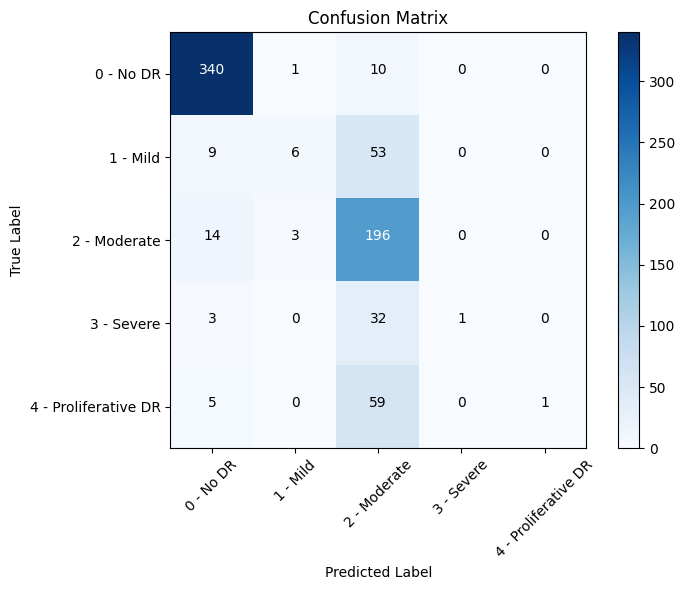

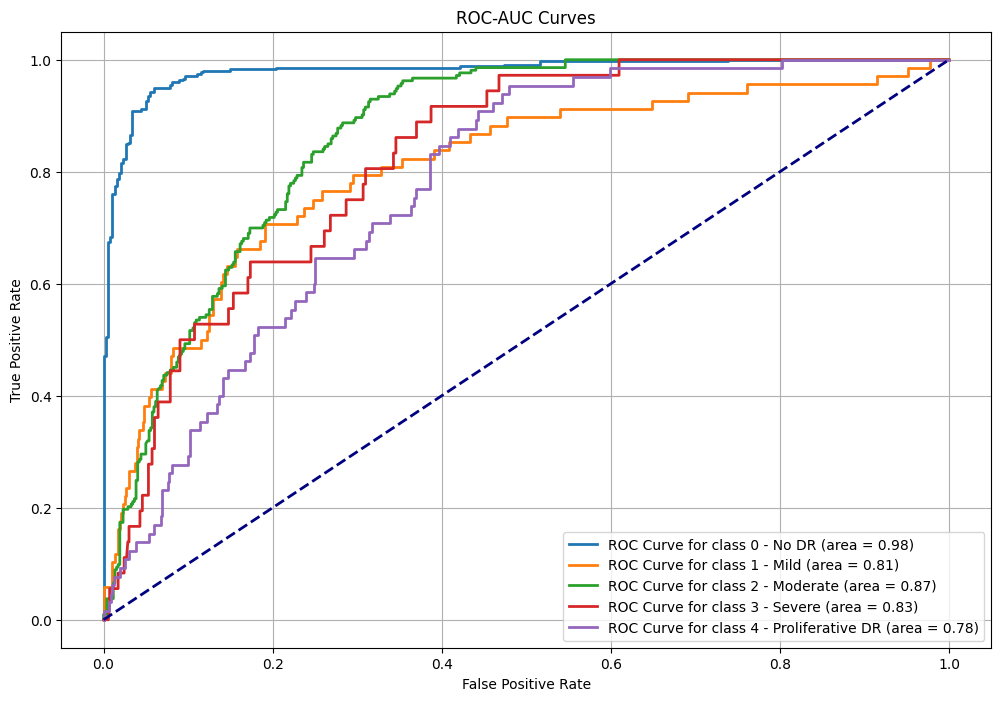

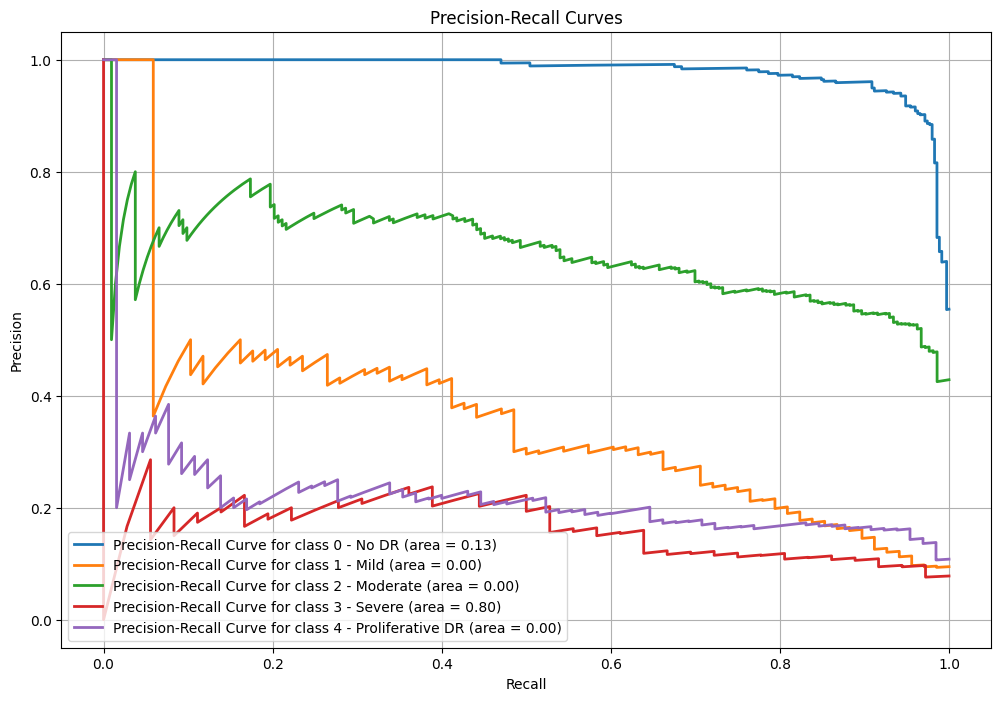

In [21]:
#Confusion Matrix
def plot_confusion_matrix(cm, class_labels, title='Confusion Matrix', cmap=plt.cm.Blues, save_dir=None):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)
    
    thresh = cm.max() / 2.0
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, f"{cm[i, j]}", horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    if save_dir:
        plt.savefig(f"{save_dir}/confusion_matrix.png", dpi=600, bbox_inches='tight')
    plt.show()

# ROC-AUC 
def plot_roc_auc_curves(true_labels, predictions, class_labels, save_dir):
    binarized_labels = tf.keras.utils.to_categorical(true_labels, num_classes=len(class_labels))
    plt.figure(figsize=(12, 8))
    for i in range(len(class_labels)):
        fpr, tpr, _ = roc_curve(binarized_labels[:, i], predictions[:, i])
        roc_auc = roc_auc_score(binarized_labels[:, i], predictions[:, i])
        plt.plot(fpr, tpr, lw=2, label=f'ROC Curve for class {class_labels[i]} (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curves')
    plt.legend(loc='lower right')
    plt.grid(True)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    plt.savefig(os.path.join(save_dir, 'roc_auc_curve.png'), dpi=600, bbox_inches='tight')
    plt.show()

# Precision-Recall
def plot_precision_recall_curves(true_labels, predictions, class_labels, save_dir):
    binarized_labels = tf.keras.utils.to_categorical(true_labels, num_classes=len(class_labels))
    plt.figure(figsize=(12, 8))
    for i in range(len(class_labels)):
        precision, recall, _ = precision_recall_curve(binarized_labels[:, i], predictions[:, i])
        pr_auc = tf.keras.metrics.AUC()(tf.convert_to_tensor(recall, dtype=tf.float32), tf.convert_to_tensor(precision, dtype=tf.float32)).numpy()
        plt.plot(recall, precision, lw=2, label=f'Precision-Recall Curve for class {class_labels[i]} (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend(loc='lower left')
    plt.grid(True)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    plt.savefig(os.path.join(save_dir, 'precision_recall_curve.png'), dpi=600, bbox_inches='tight')
    plt.show()

plot_confusion_matrix(cm, class_labels, title='Confusion Matrix', save_dir=save_dir)
plot_roc_auc_curves(true_labels, predictions, class_labels, save_dir)
plot_precision_recall_curves(true_labels, predictions, class_labels, save_dir)

In [22]:
#lime

  0%|          | 0/1000 [00:00<?, ?it/s]

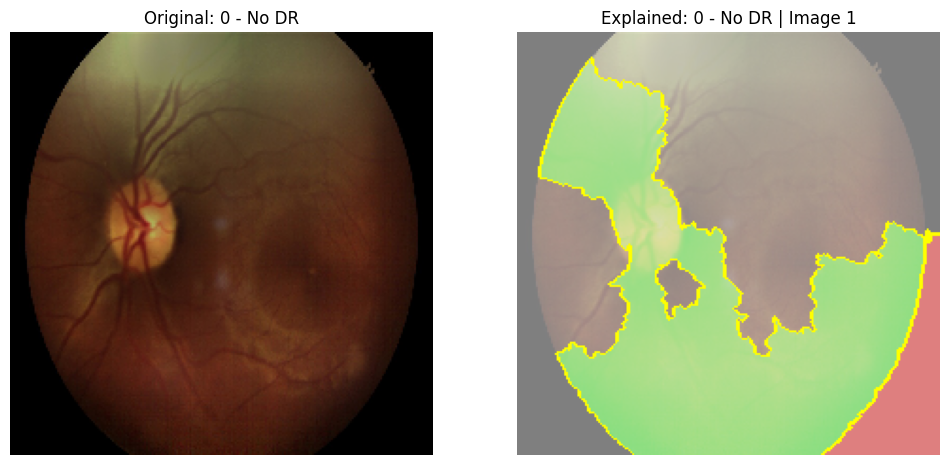

  0%|          | 0/1000 [00:00<?, ?it/s]

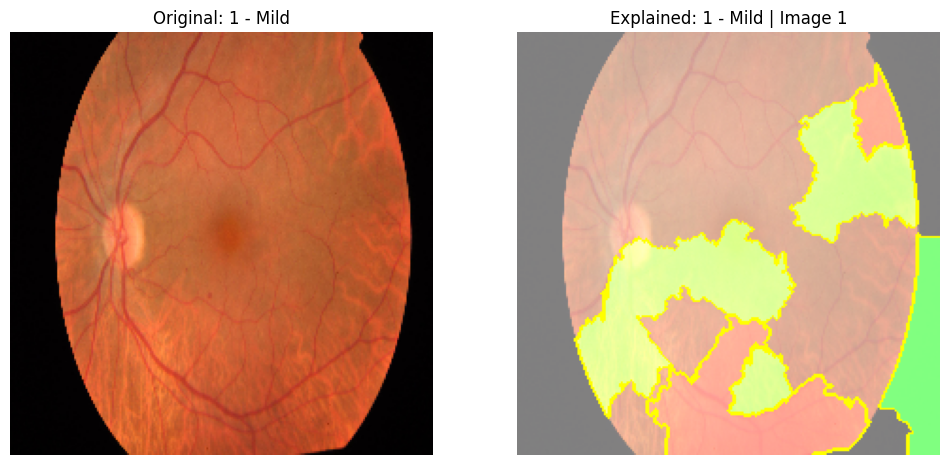

  0%|          | 0/1000 [00:00<?, ?it/s]

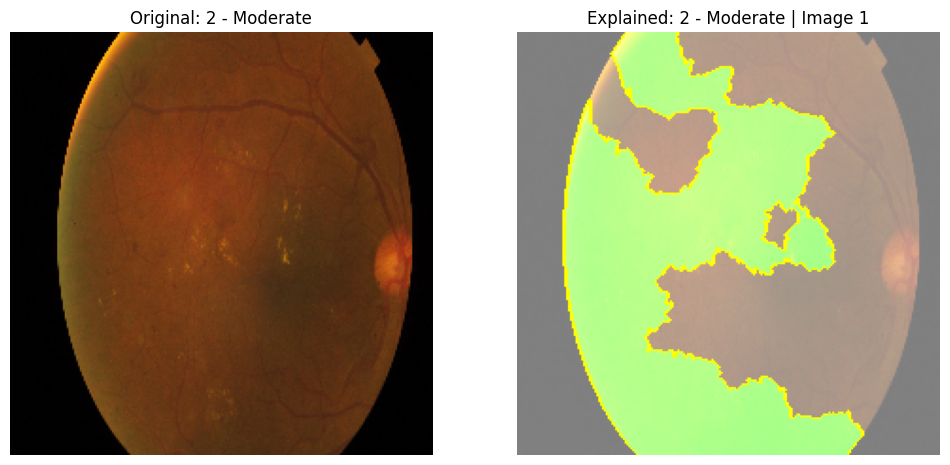

  0%|          | 0/1000 [00:00<?, ?it/s]

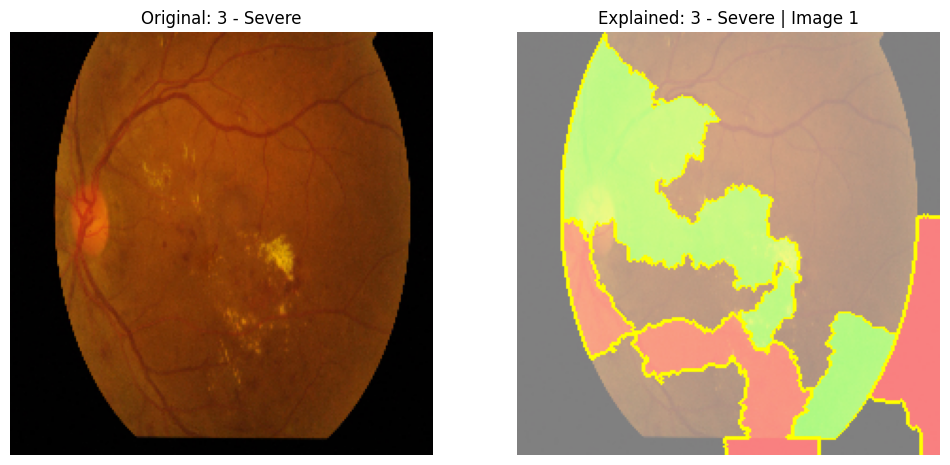

  0%|          | 0/1000 [00:00<?, ?it/s]

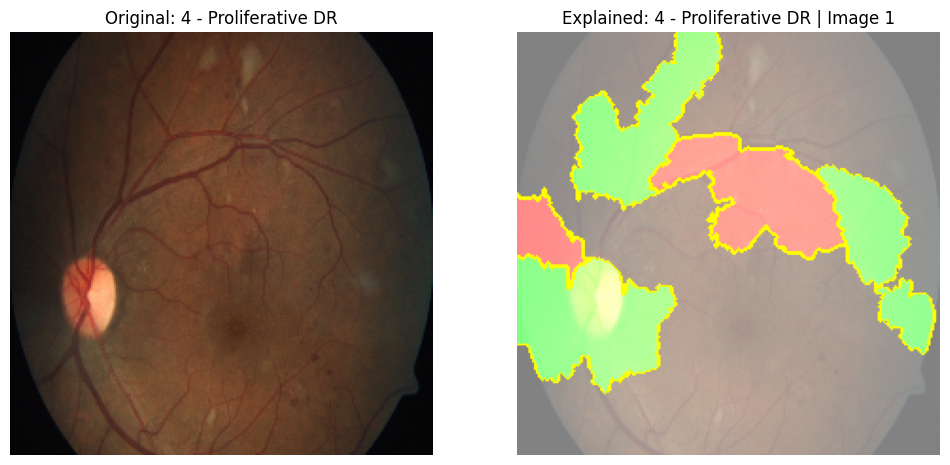

In [23]:
explainer = lime_image.LimeImageExplainer()

def model_predict(image_batch):
    return model.predict(image_batch)

class_labels = list(test_generator.class_indices.keys())

num_images = 1
class_images = {label: [] for label in class_labels}

for images, labels in test_generator:
    for i, label in enumerate(labels):
        label_index = np.argmax(label)
        class_name = class_labels[label_index]
        if len(class_images[class_name]) < num_images:
            class_images[class_name].append(images[i])
    if all(len(class_images[label]) >= num_images for label in class_labels):
        break
save_dir = "plots/lime"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
for class_name, images in class_images.items():
    for idx, img in enumerate(images):
        explanation = explainer.explain_instance(
            img.astype('double'),
            model_predict,
            top_labels=1,
            num_samples=1000
        )
        temp, mask = explanation.get_image_and_mask(
            explanation.top_labels[0],
            positive_only=False,
            num_features=10
        )
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        plt.imshow(img) 
        plt.title(f"Original: {class_name}")
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
        plt.title(f"Explained: {class_name} | Image {idx + 1}")
        plt.axis('off')
        
        save_path = os.path.join(save_dir, f"{class_name}_image_{idx + 1}.png")
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()


In [ ]:
import gc

K.clear_session()
gc.collect()
del model

In [ ]:
from numba import cuda

cuda.select_device(0)
cuda.close()